Tema ovog rada je detekcija vozačeve nepažnje. Koristi se skup podataka koji se sastoji od slika kategorizovanih u 10 različitih klasa (devet raličitih nepažljivih aktivnosti i jedna aktivnost koja demonstrira sigurnu vožnju).
Skup podataka je dostupan na adresi https://www.kaggle.com/c/state-farm-distracted-driver-detection/data .

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

#potreban je python openCv koji je potrebno instalirati komandom conda install -c menpo opencv
import cv2

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics



In [151]:
import seaborn as sns


In [82]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# 1. Učitavanje podataka

## Opis skupa podataka

In [23]:
# promenljiva df sadrži označene podatke
df = pd.read_csv('../data/driver_imgs_list.csv')
print(df)

      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]


In [11]:
# mapa aktivnosti 
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

Sledeći kod daje prikaz po jedne od slika iz svake klase

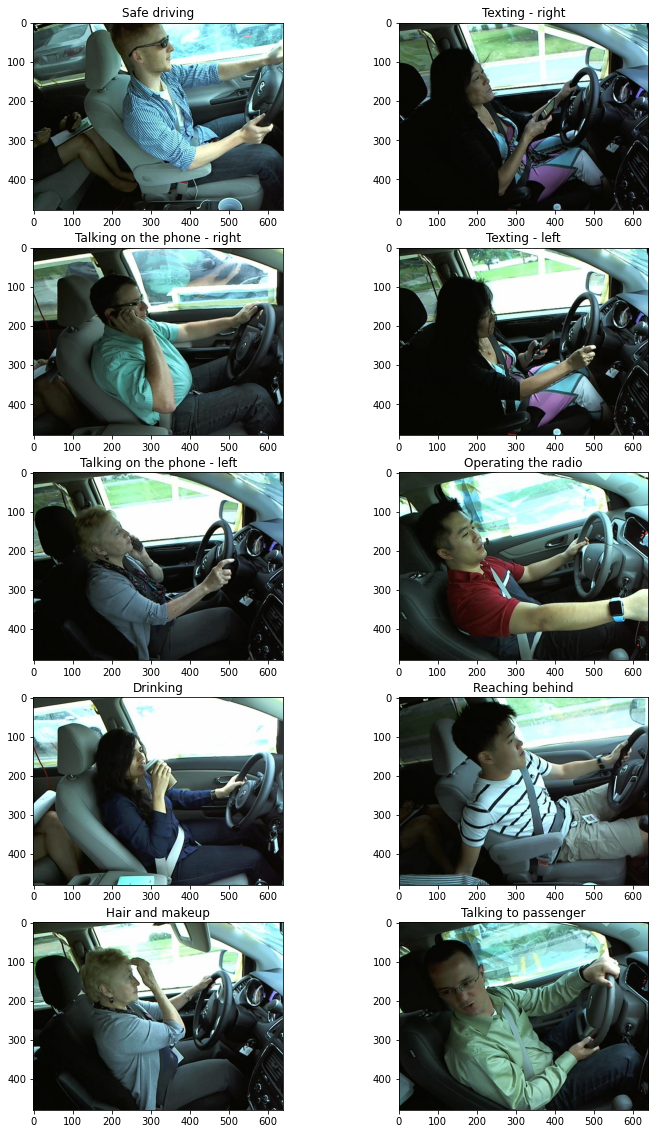

In [14]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../data/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

Na sledećem dijagramu prikazana je distribucija klasa u skupu:

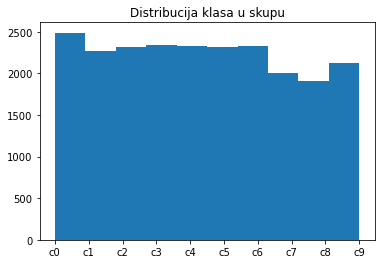

In [79]:
plt.hist(df['classname'])
plt.title('Distribucija klasa u skupu')
plt.show()

Na osnovu dijagrama zaključujemo da je skup balansiran.

## Priprema podataka

Radi lakšeg rada, slike ćemo normalizovati (svesti vrednosti pojedinačnih piksela na vrednost iz intervala iz [0, 1])  i  smanjiti im rezoluciju. 

U nastavku je dat primer slike i njen prikaz u originalnoj i smanjenoj rezoluciji. 

In [8]:
# Primer slike
example_img = cv2.imread("../data/train/c0/img_44733.jpg")
example_img_resized = cv2.resize(cv2.imread('../data/train/c0/img_44733.jpg'), (160, 120), interpolation=cv2.INTER_NEAREST)
print('Originalna dimenzija slike: {}'.format(example_img.shape))
print('Smanjena dimenzija slike: {}'.format(example_img_resized.shape))


Originalna dimenzija slike: (480, 640, 3)
Smanjena dimenzija slike: (120, 160, 3)


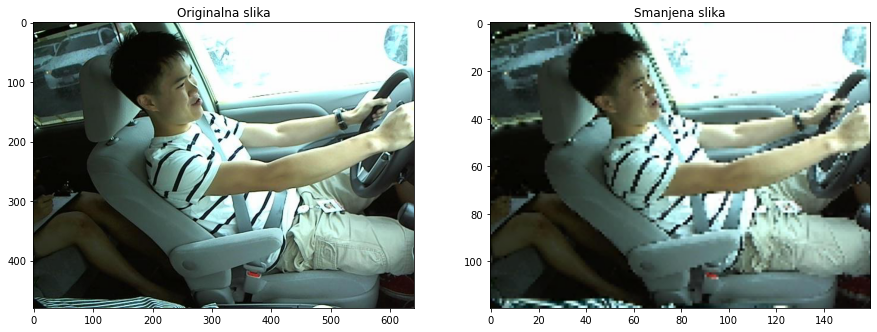

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].imshow(example_img[:,:,::-1])
ax[0].title.set_text('Originalna slika')
ax[1].imshow(example_img_resized[:,:,::-1])
ax[1].title.set_text('Smanjena slika')
plt.show()

In [21]:
# Funkcija zadužena za normalizaciju i promenu dimenzije slike
def normalize_and_resize(image):
  image_resized = cv2.resize(image, (160, 120)) #resize the image to 120x160
  image_data = image_resized/255 # Normalize the image
  return image_data

In [28]:
number_of_images = df.shape[0]
X = np.ndarray(shape = (number_of_images, 120, 160, 3), dtype = np.float32)

for index, row in df.iterrows():
  image = cv2.imread('../data/train/'+row['classname']+'/'+row['img'])
  image_array = normalize_and_resize(image)
  X[index,:,:,:] = image_array 

#Kodiramo tip 'classname' u numeričku vrednost
y = pd.factorize(df['classname'])[0]

print('Dimenzija X: {}'.format(X.shape)) 
print('Dimenzija y: {}'.format(y.shape))

Dimenzija X: (22424, 120, 160, 3)
Dimenzija y: (22424,)


## Podela podataka na skup za treniranje i skup za testiranje

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [34]:
# Zbog prevelike količine podataka, oslobađamo memoriju koja se više ne koristi
del X, y

# 2. Pravljenje modela

## Osnovni model

### SVM

In [40]:
# model_svm = svm.SVC(kernel='rbf', C=1000, gamma=0.1)
# model_svm.fit(X_train.reshape(X_train.shape[0], -1), y_train)

Nije bilo moguće napraviti SVM kalsifikacioni model zbog nedostatka RAM memorije. 

### Slučajne šume (Random forest)

In [242]:
model_forest = ensemble.RandomForestClassifier(n_estimators=10, random_state=123)

In [243]:
model_forest.fit(X_train.reshape(X_train.shape[0], -1), y_train)

RandomForestClassifier(n_estimators=10, random_state=123)

In [246]:
y_predict_rf = model_forest.predict(X_test.reshape(X_test.shape[0], -1))

In [247]:
confusion_matrix_rf = metrics.confusion_matrix(y_test, y_predict_rf, normalize='true')

Definišemo funkciju koja radi prikaz matrice konfuzije:

In [248]:
def plot_confusion_matrix(conf):    
    fig, ax = plt.subplots(figsize=(13, 13))
    plt.title('Matrica konfuzije')
    sns.heatmap(conf, annot=True, fmt='.5f', cmap=plt.cm.Blues, ax=ax)
    plt.xlabel('Predviđene vrednosti')
    plt.ylabel('Stvarne vrednosti')
    plt.show()

U nastavku je prikazana matrica konfuzije modela.

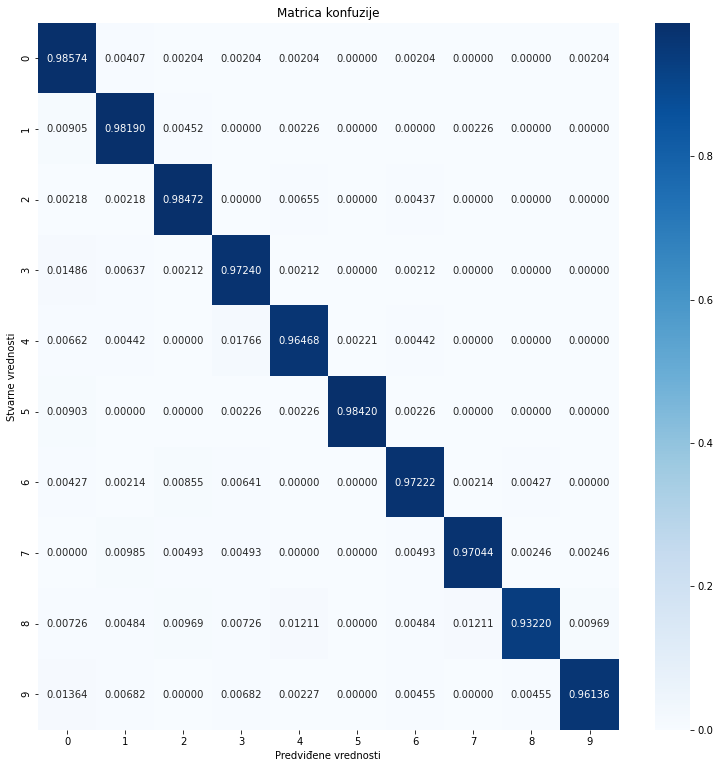

In [249]:
plot_confusion_matrix(confusion_matrix_rf)

In [280]:
#Tačnost i r2_score
accuracy_rf = metrics.accuracy_score(y_test, y_predict_rf)
r2_rf = metrics.r2_score(y_test, y_predict_rf)
precision_
print('Tačnost modela je: {}'.format(accuracy_rf))
print('R2 score je: {}'.format(r2_rf))



Tačnost modela je: 0.9714604236343367
R2 score je: 0.9354296491023112


In [251]:
report_rf = metrics.classification_report(y_test, y_predict_rf)

In [216]:
print(report_rf)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       491
           1       0.96      0.98      0.97       442
           2       0.97      0.98      0.98       458
           3       0.96      0.97      0.96       471
           4       0.97      0.96      0.97       453
           5       1.00      0.98      0.99       443
           6       0.97      0.97      0.97       468
           7       0.98      0.97      0.98       406
           8       0.99      0.93      0.96       413
           9       0.99      0.96      0.97       440

    accuracy                           0.97      4485
   macro avg       0.97      0.97      0.97      4485
weighted avg       0.97      0.97      0.97      4485



Na osnovu dobijenih rezultata možemo zaključiti da je model prilično dobar. Ipak, pokušaćemo malo da poboljšamo rezultat korišćenjem neuronskih mreža.

## Konvolutivna neuronska mreža

### CNN model

In [217]:
model_cnn = models.Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))

model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(10))

In [184]:
print('Prikaz modela i uvid u broj parametara koje mreža treba da nauči: \n')
model_cnn.summary()

Prikaz modela i uvid u broj parametara koje mreža treba da nauči: 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 38, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 36, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 59904)             0         
____________________________________________________

#### Treniranje mreže

Funkcija gubitka koju mreža minimizuje će biti `kategorička unakrsna entropija`. Za treniranje mreže ćemo koristiti optimizator `Adam`, a za metriku biće uzeta tačnost pošto rešavamo klasifikacioni zadatak.

In [219]:
#default learning_rate za adam optimizator je 0.001
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Mrežu ćemo trenirati koristeći paketiće veličine 32 u 20 epoha.

In [220]:
batch_size = 32
epochs = 20

In [221]:
history = model_cnn.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/20
505/505 [==============================] - 475s 939ms/step - loss: 0.4501 - accuracy: 0.8535 - val_loss: 0.0828 - val_accuracy: 0.9749
Epoch 2/20
505/505 [==============================] - 482s 955ms/step - loss: 0.0439 - accuracy: 0.9872 - val_loss: 0.0698 - val_accuracy: 0.9833
Epoch 3/20
505/505 [==============================] - 486s 963ms/step - loss: 0.0163 - accuracy: 0.9957 - val_loss: 0.0436 - val_accuracy: 0.9866
Epoch 4/20
505/505 [==============================] - 460s 910ms/step - loss: 0.0183 - accuracy: 0.9952 - val_loss: 0.0526 - val_accuracy: 0.9861
Epoch 5/20
505/505 [==============================] - 422s 835ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0418 - val_accuracy: 0.9905
Epoch 6/20
505/505 [==============================] - 439s 869ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0245 - val_accuracy: 0.9961
Epoch 7/20
505/505 [==============================] - 423s 838ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.0472 -

Definisaćemo funkciju koja iscrtava grafike funkcije gubitka i tačnosti u toku treniranja

In [222]:
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1,2,1)
    plt.title('Model loss')   
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Model accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')

    plt.show()

Grafici funkcije gubitka i tačnosti u toku treniranja:

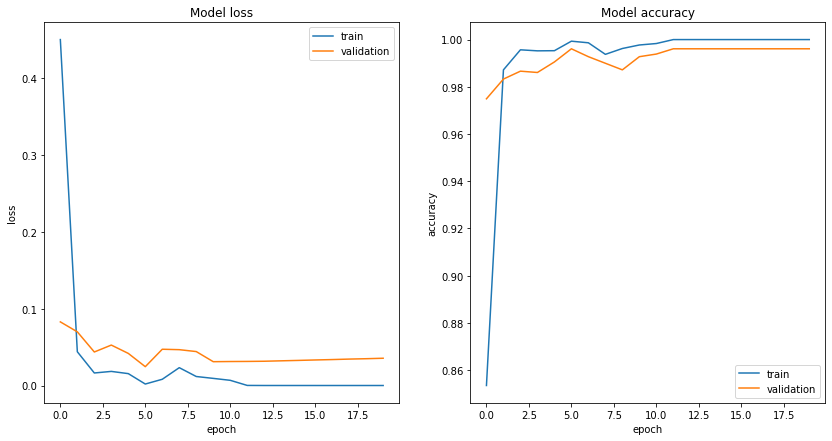

In [223]:
plot_loss_and_accuracy(history)

Na grafiku se vidi da gubitak na validacionom skupu blago raste posle desete epohe, a da tačnost više ne menja vrednost. Na osnovu toga možemo zaključiti da nam je 10 epoha dovoljno za treniranje mreže. Kreiramo sada finalni model:

In [224]:
model_cnn_final = models.Sequential()
model_cnn_final.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 160, 3)))
model_cnn_final.add(MaxPooling2D((2, 2)))
model_cnn_final.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_final.add(MaxPooling2D((2, 2)))
model_cnn_final.add(Conv2D(64, (3, 3), activation='relu'))

model_cnn_final.add(Flatten())
model_cnn_final.add(Dense(64, activation='relu'))
model_cnn_final.add(Dense(10))

In [226]:
print('Prikaz modela i uvid u broj parametara koje mreža treba da nauči: \n')
model_cnn_final.summary()

Prikaz modela i uvid u broj parametara koje mreža treba da nauči: 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 57, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 38, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 36, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 59904)             0         
____________________________________________________

In [228]:
#treniramo mrežu na isti način kao ranije
model_cnn_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [231]:
batch_size = 32
epochs = 10

In [232]:
history = model_cnn_final.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
561/561 [==============================] - 443s 790ms/step - loss: 0.0896 - accuracy: 0.9756
Epoch 2/10
561/561 [==============================] - 354s 630ms/step - loss: 0.0322 - accuracy: 0.9914
Epoch 3/10
561/561 [==============================] - 363s 648ms/step - loss: 0.0249 - accuracy: 0.9938
Epoch 4/10
561/561 [==============================] - 359s 639ms/step - loss: 0.0106 - accuracy: 0.9969
Epoch 5/10
561/561 [==============================] - 360s 641ms/step - loss: 0.0262 - accuracy: 0.9936
Epoch 6/10
561/561 [==============================] - 358s 638ms/step - loss: 0.0033 - accuracy: 0.9992
Epoch 7/10
561/561 [==============================] - 361s 643ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 8/10
561/561 [==============================] - 379s 676ms/step - loss: 0.0169 - accuracy: 0.9948
Epoch 9/10
561/561 [==============================] - 377s 672ms/step - loss: 0.0220 - accuracy: 0.9936
Epoch 10/10
561/561 [==============================] - 346s 616m

#### Analiza i evaluacija modela

In [233]:
y_predict_cnn = model_cnn_final.predict(X_test)

In [234]:
y_test.shape

(4485,)

In [235]:
y_predict_classes = np.argmax(y_predict_cnn, axis=1)
y_predict_classes.shape

(4485,)

In [236]:
confusion_matrix_cnn = metrics.confusion_matrix(y_test, y_predict_classes, normalize='true')

U nastavku su prikazani tačnost modela i matrica konfuzije

In [266]:
accuracy_cnn = metrics.accuracy_score(y_test, y_predict_classes)
#recall_cnn = metrics.recall_score(y_test, y_predict_classes) 
r2_cnn = metrics.r2_score(y_test, y_predict_classes)
#precision_cnn = metrics.precision_score(y_test, y_predict_classes)
print('Tačnost je: {}'.format(accuracy_cnn))
#print(recall_cnn)
print('R2 score je: {}'.format(r2_cnn))
#print(precision_cnn)


Tačnost je: 0.9919732441471572
R2 score je: 0.9853298324111108


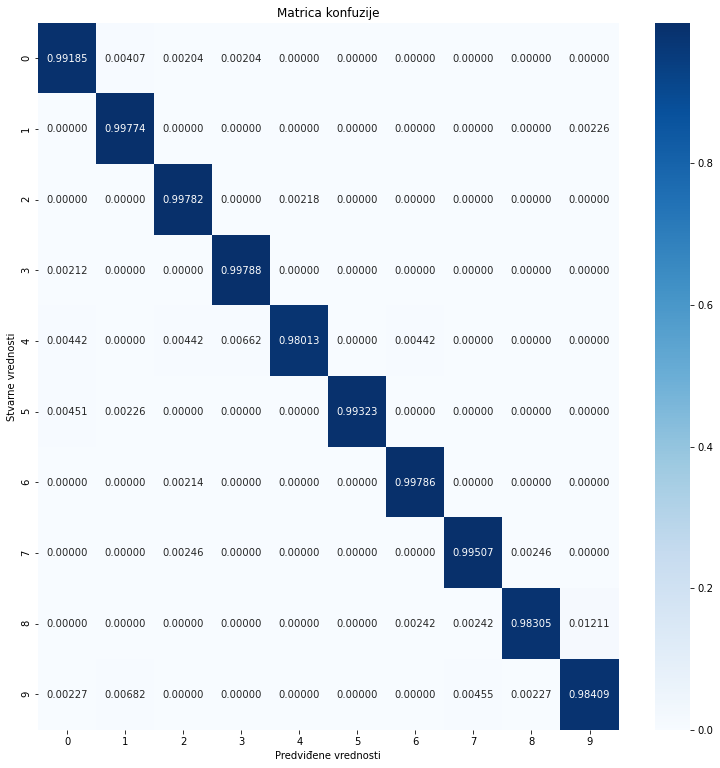

In [238]:
plot_confusion_matrix(confusion_matrix_cnn)

In [239]:
report_cnn = metrics.classification_report(y_test, y_predict_classes)

In [240]:
print(report_cnn)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       491
           1       0.99      1.00      0.99       442
           2       0.99      1.00      0.99       458
           3       0.99      1.00      0.99       471
           4       1.00      0.98      0.99       453
           5       1.00      0.99      1.00       443
           6       0.99      1.00      1.00       468
           7       0.99      1.00      0.99       406
           8       1.00      0.98      0.99       413
           9       0.99      0.98      0.99       440

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485



Na osnovu dobijenih rezultata vidimo da je ovaj model bolji od prethodnog. 

## Poređenje osnovnog modela i modela neuronskih mreža

U nastavku je prikazan grafik sa stubićima na kome su upoređene performanse pomenutih modela. 

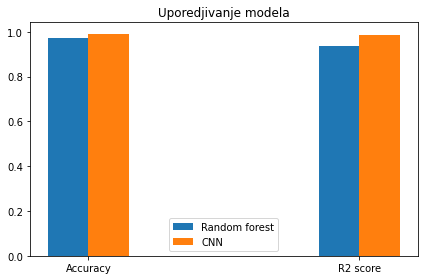

In [275]:
labels = ['Accuracy', 'R2 score']
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [accuracy_rf, r2_rf], width, label='Random forest')
rects2 = ax.bar(x + width/2, [accuracy_cnn, r2_cnn], width, label='CNN')

ax.set_title('Uporedjivanje modela')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Na osnovu grafika možemo zaključiti da bolje performanse ima CNN model.

CNN model ćemo sačuvati.

In [276]:
model_cnn_path = 'distracted_driver_classifier.h5'
model_cnn_final.save(model_path)